# Dog Breed Classifier

<img src="n02112018_150.jpg" style="width:1200px;height:400px;">

## Goals:
### 1. Reuse Inception V3 model to train on dog breed data
### 2. Freeze most of the layers
### 3. Cut top layer and add new Fully COnnected layer
### 4. Retrain just top layers
### 5. EValuate Model


### Import python packages

In [ ]:
pip install keras

In [ ]:


from keras import regularizers
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Dropout
from keras.layers import GlobalAveragePooling2D
from keras.layers import BatchNormalization
from keras.layers import Activation,Dense
from keras.models import Sequential,load_model
from tensorflow.keras.utils import img_to_array,load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd
from numpy.random import rand
from keras.callbacks import ModelCheckpoint

# Scikit Imports
from sklearn.model_selection import train_test_split
# Matplot Imports
import matplotlib.pyplot as plt
from keras.models import model_from_json

import seaborn as sns


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Intialize matplotlib parameters

pd.options.display.max_colwidth = 600


params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

plt.rcParams.update(params)
%matplotlib inline

# pandas display data frames as tables
from IPython.display import display, HTML

import warnings
warnings.filterwarnings('ignore')

## Get Dataset

The Stanford Dog breed dataset is available at [Kaggle/Dogbreed](https://www.kaggle.com/c/dog-breed-identification/data).

The download consists of train, test and label files

In [ ]:
train_folder = '/content/drive/MyDrive/train/train/'
test_folder = '/content/drive/MyDrive/test/'


In [ ]:
data_labels = pd.read_csv('/content/drive/MyDrive/labels.csv')
data_labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [ ]:
data_labels.describe()

,id,breed
count,10222,10222
unique,10222,120
top,000bec180eb18c7604dcecc8fe0dba07,scottish_deerhound
freq,1,126


## Check Number of Classes in the Dataset

The dataset contain 120 different dog breeds

In [ ]:
target_labels = data_labels['breed']
len(set(target_labels))
print(target_labels[0:5])

0         boston_bull
1               dingo
2            pekinese
3            bluetick
4    golden_retriever
Name: breed, dtype: object


## Prepare Labels
Deep Learning models work with one hot encoded outputs or target variables. We utilize pandas to prepare one hot encoding for the labels.

In [ ]:
labels_ohe_names = pd.get_dummies(target_labels, sparse=True)

print(labels_ohe_names.shape)
labels_ohe = np.asarray(labels_ohe_names)
labels_ohe_names.to_csv("labels.csv")
print(type(labels_ohe_names))
print(labels_ohe.shape)
print(labels_ohe[0:5])
labels_ohe_names.head()

(10222, 120)
<class 'pandas.core.frame.DataFrame'>
(10222, 120)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We add another column to the labels dataset to identify image path

In [ ]:
data_labels['image_path'] = data_labels.apply( lambda row: (train_folder + row["id"] + ".jpg" ), axis=1)
data_labels.head()

,id,breed,image_path
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,/content/drive/MyDrive/train/train/000bec180eb18c7604dcecc8fe0dba07.jpg
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,/content/drive/MyDrive/train/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg
2,001cdf01b096e06d78e9e5112d419397,pekinese,/content/drive/MyDrive/train/train/001cdf01b096e06d78e9e5112d419397.jpg
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,/content/drive/MyDrive/train/train/00214f311d5d2247d5dfe4fe24b2303d.jpg
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,/content/drive/MyDrive/train/train/0021f9ceb3235effd7fcde7f7538ed62.jpg


### Understand Data


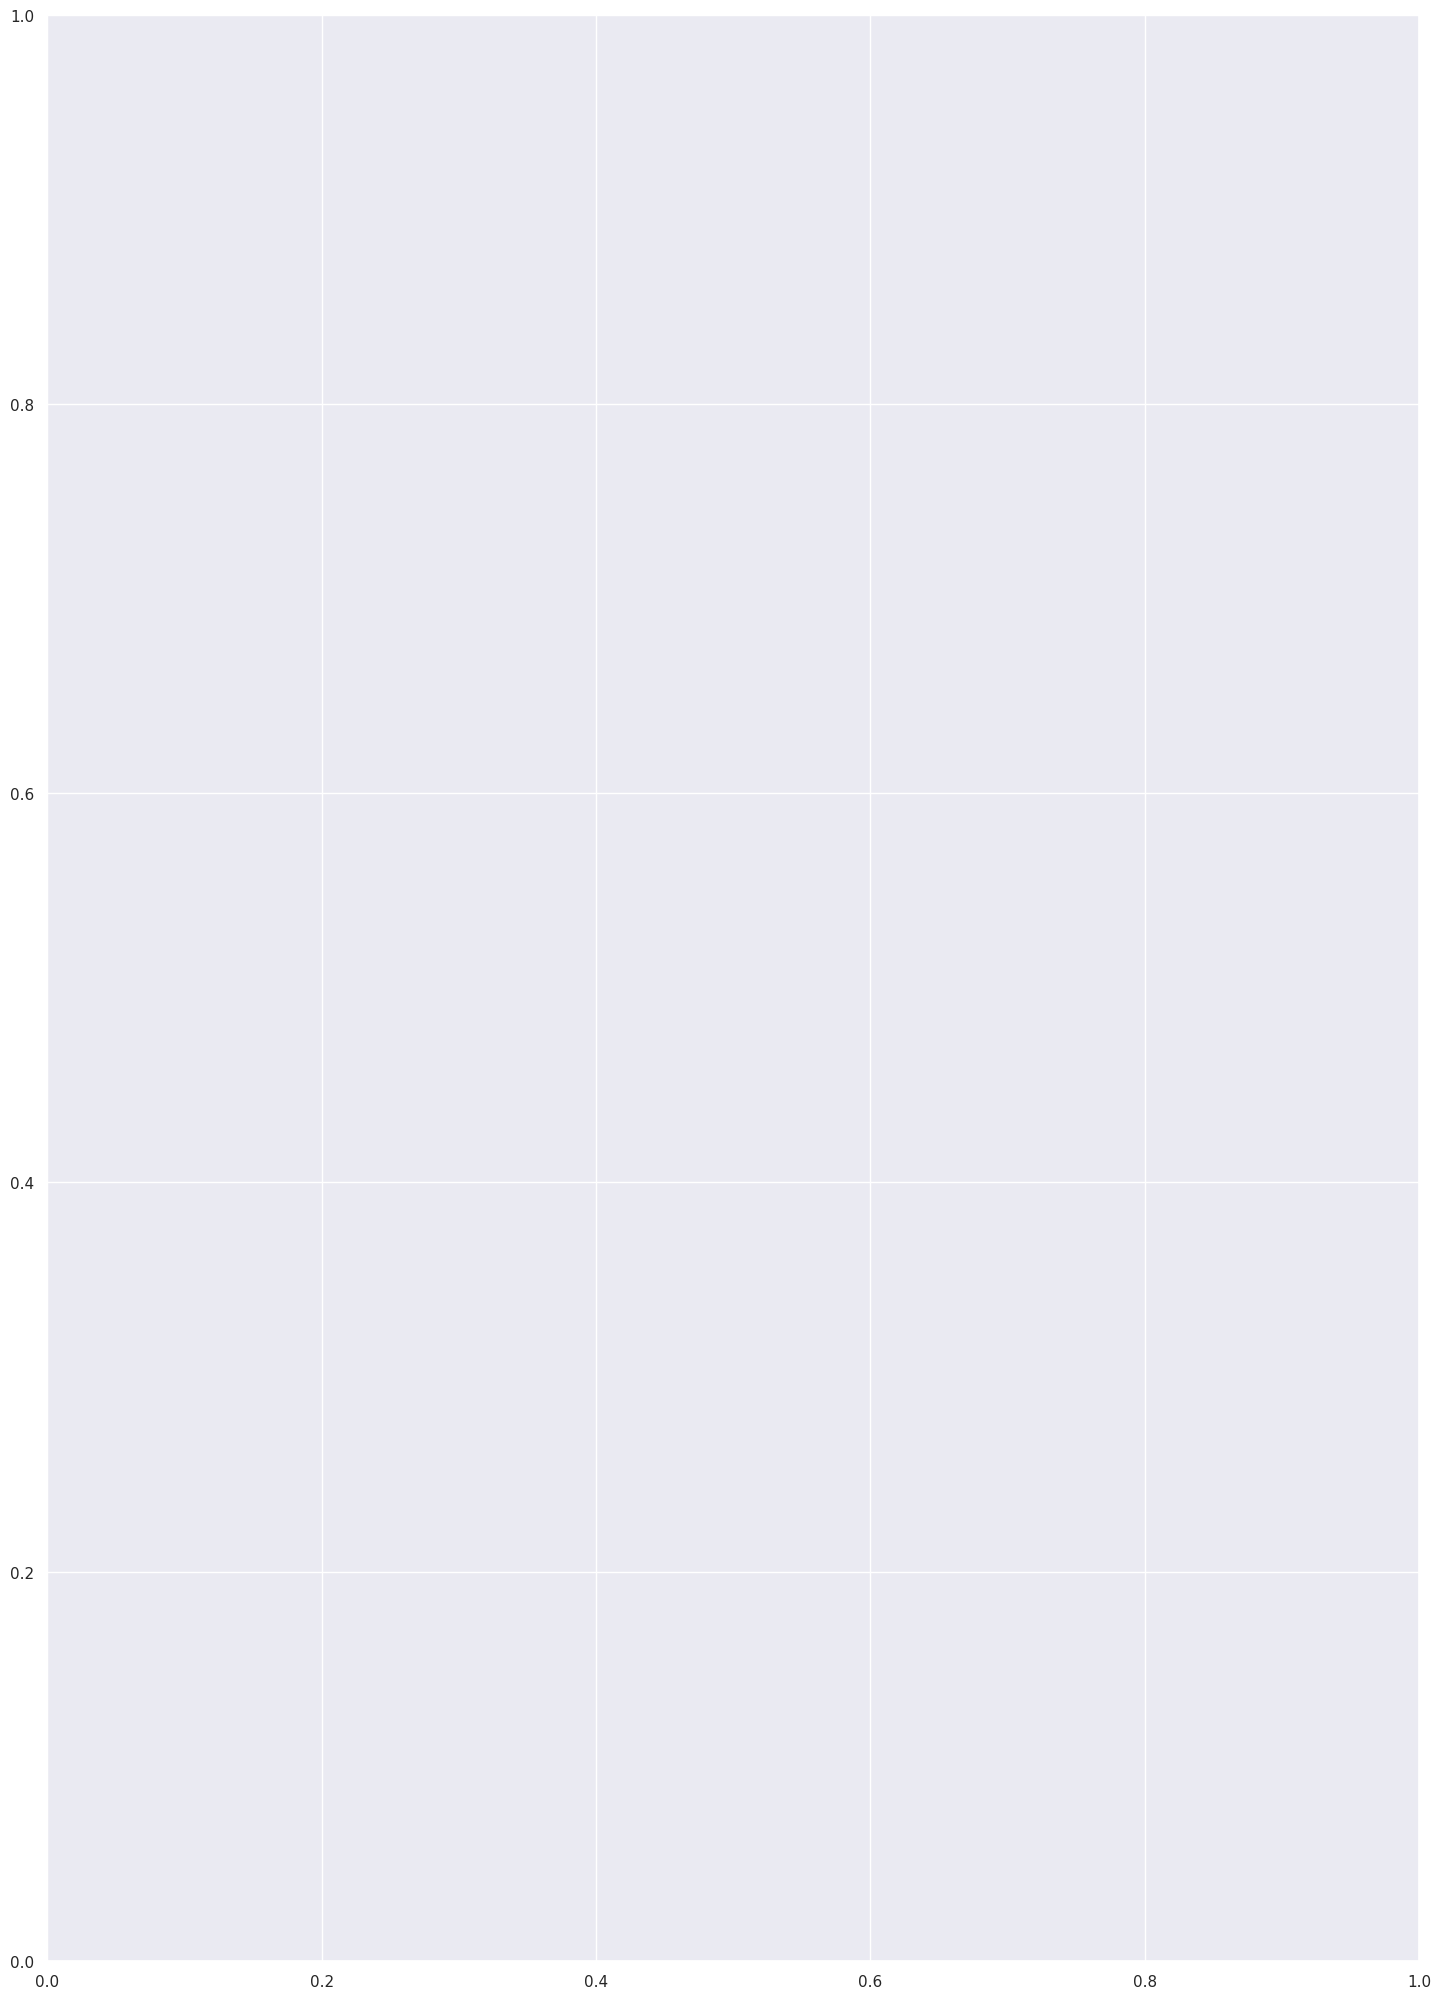

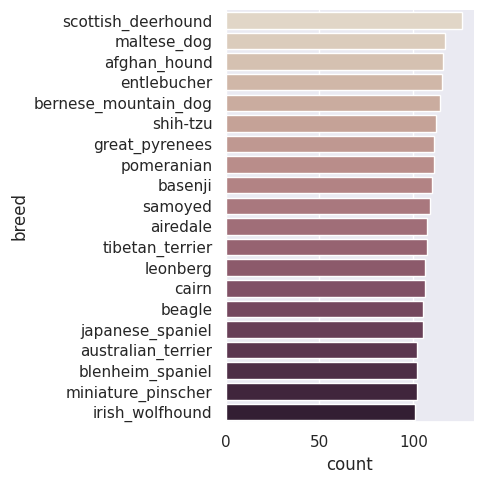

In [ ]:
sns.set(style="darkgrid")
sns.set(color_codes=True)
fig, ax = plt.subplots()
fig.set_size_inches(17.7, 25.27)
sns.catplot(y="breed",   kind="count", palette="ch:.25",ax=ax, data=data_labels, order=data_labels.breed.value_counts().iloc[:20].index);


## Prepare Train-Test Datasets
We use a 70-30 split to prepare the two dataset.

In [ ]:
train_data = np.array([img_to_array(
                            load_img(img,
                                     target_size=(299, 299))
                       ) for img
                           in data_labels['image_path'].values.tolist()
                      ]).astype('float32')

In [ ]:
img = plt.imread('/content/drive/MyDrive/train/train/000bec180eb18c7604dcecc8fe0dba07.jpg')

In [ ]:
type(img)

numpy.ndarray

In [ ]:
img.shape

(375, 500, 3)

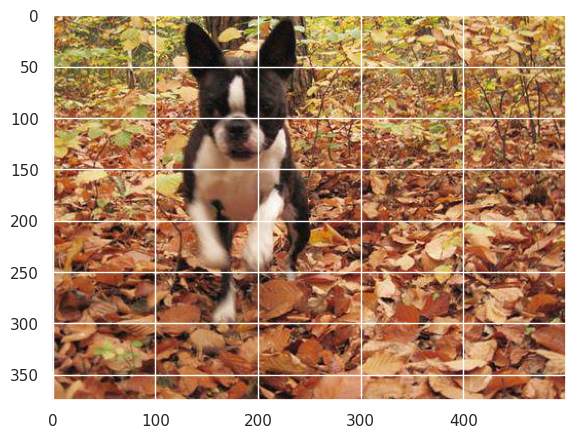

In [ ]:
plt.imshow(img)

In [ ]:
train_data.shape

(10222, 299, 299, 3)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(train_data,
                                                    target_labels,
                                                    test_size=0.3,
                                                    stratify=np.array(target_labels),
                                                    random_state=42)

In [ ]:
x_train.shape, x_test.shape

((7155, 299, 299, 3), (3067, 299, 299, 3))

Prepare Validation Dataset

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train,
                                                    y_train,
                                                    test_size=0.15,
                                                    stratify=np.array(y_train),
                                                    random_state=42)

In [ ]:
x_train.shape, x_val.shape

((6081, 299, 299, 3), (1074, 299, 299, 3))

In [ ]:
print(y_train.shape)

(6081,)


Prepare target variables for train, test and validation datasets

In [ ]:
y_train_ohe = pd.get_dummies(y_train.reset_index(drop=True)).values
y_val_ohe = pd.get_dummies(y_val.reset_index(drop=True)).values
y_test_ohe = pd.get_dummies(y_test.reset_index(drop=True)).values

y_train_ohe.shape, y_test_ohe.shape, y_val_ohe.shape

((6081, 120), (3067, 120), (1074, 120))

## Data Augmentation

Since number of samples per class are not very high, we utilize data augmentation to prepare different variations of different samples available. We do this using the ```ImageDataGenerator utility``` from ```keras```

In [ ]:
BATCH_SIZE = 32

In [ ]:
# Create train generator.
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip = 'true')
train_generator = train_datagen.flow(x_train, y_train_ohe, shuffle=False, batch_size=BATCH_SIZE, seed=1)

In [ ]:
# Create validation generator
val_datagen = ImageDataGenerator(rescale = 1./255)
val_generator = train_datagen.flow(x_val, y_val_ohe, shuffle=False, batch_size=BATCH_SIZE, seed=1)

## Prepare Deep Learning Classifier

* Load InceptionV3 pretrained on ImageNet without its top/classification layer
* Add additional custom layers on top of InceptionV3 to prepare custom classifier

In [ ]:
# Get the InceptionV3 model so we can do transfer learning
base_inception = InceptionV3(weights='imagenet', include_top = False, input_shape=(299, 299, 3))
print(base_inception.summary())

87910968/87910968 [==============================] - 0s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)           

In [ ]:
# Add a global spatial average pooling layer
out = base_inception.output
out = GlobalAveragePooling2D()(out)
out = Dense(512, activation='relu')(out)
out = Dense(512, activation='relu')(out)
total_classes = y_train_ohe.shape[1]
predictions = Dense(total_classes, activation='softmax')(out)

* Stack the two models (InceptionV3 and custom layers) on top of each other
* Compile the model and view its summary

In [ ]:
model = Model(inputs=base_inception.input, outputs=predictions)

# only if we want to freeze layers
for layer in base_inception.layers:
    layer.trainable = False

model.summary()
# Compile
model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

## Model Training
We train the model with a Batch Size of 32 for just 15 Epochs.

The model utilizes the power of transfer learning to achieve a validation accuracy of about __81%__ !

In [ ]:
# Train the model
batch_size = BATCH_SIZE
train_steps_per_epoch = x_train.shape[0] // batch_size
val_steps_per_epoch = x_val.shape[0] // batch_size
checkpoint = ModelCheckpoint('model-{epoch:03d}-{accuracy:03f}-{val_accuracy:03f}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')

history = model.fit_generator(train_generator,
                              steps_per_epoch=train_steps_per_epoch,
                              validation_data=val_generator,
                              validation_steps=val_steps_per_epoch,
                              epochs=15,
                              callbacks=[checkpoint],
                              verbose=True)

Epoch 1/15
190/190 [==============================] - ETA: 0s - loss: 3.5725 - accuracy: 0.3900
Epoch 1: val_loss improved from inf to 1.73752, saving model to model-001-0.389982-0.721591.h5
190/190 [==============================] - 215s 1s/step - loss: 3.5725 - accuracy: 0.3900 - val_loss: 1.7375 - val_accuracy: 0.7216
Epoch 2/15
190/190 [==============================] - ETA: 0s - loss: 1.1235 - accuracy: 0.7649
Epoch 2: val_loss improved from 1.73752 to 0.83820, saving model to model-002-0.764920-0.787879.h5
190/190 [==============================] - 198s 1s/step - loss: 1.1235 - accuracy: 0.7649 - val_loss: 0.8382 - val_accuracy: 0.7879
Epoch 3/15
190/190 [==============================] - ETA: 0s - loss: 0.7094 - accuracy: 0.8081
Epoch 3: val_loss improved from 0.83820 to 0.69511, saving model to model-003-0.808067-0.802083.h5
190/190 [==============================] - 197s 1s/step - loss: 0.7094 - accuracy: 0.8081 - val_loss: 0.6951 - val_accuracy: 0.8021
Epoch 4/15
190/190 [===

Save the Model

In [ ]:
model.save('dog_breed.hdf5')

## Visualize Model Performance

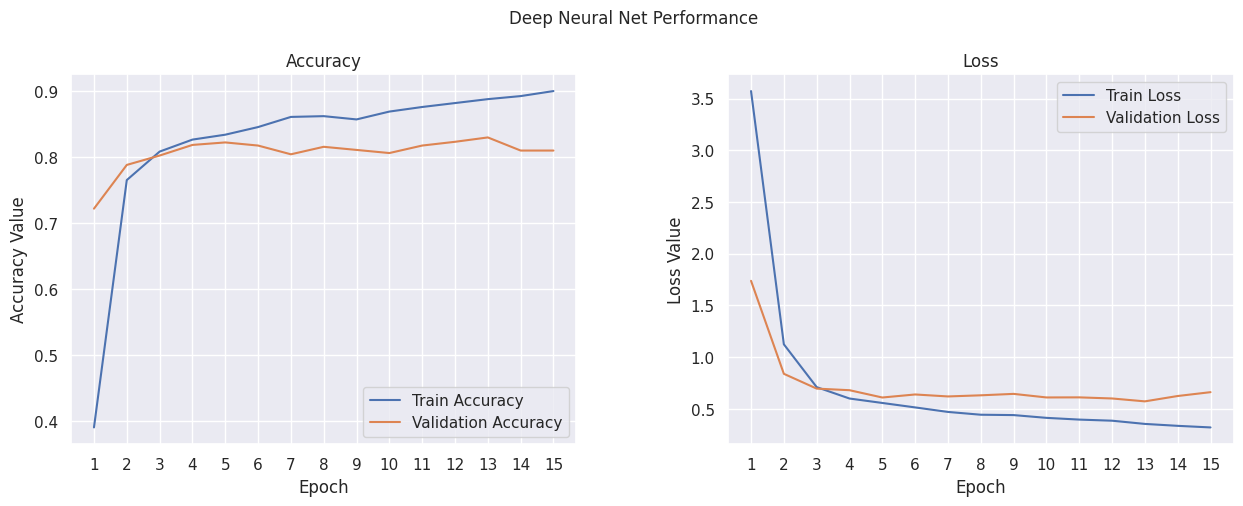

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
t = f.suptitle('Deep Neural Net Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = list(range(1,16))
ax1.plot(epochs, history.history['accuracy'], label='Train Accuracy')
ax1.set_xticks(epochs)
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epochs, history.history['loss'], label='Train Loss')
ax2.set_xticks(epochs)
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

## Test Model Performance

Step 1 is to prepare the training dataset. Since we scaled training data, test data should also be scaled in a similar manner.

_Note: Deep Learning models are very sensitive to scaling._

In [ ]:
# scaling test features
x_test /= 255.

In [ ]:
test_predictions = model.predict(x_test)
test_predictions

96/96 [==============================] - 53s 539ms/step


array([[1.3435996e-04, 4.4702329e-06, 1.0877843e-04, ..., 6.3517648e-03,
        9.0448912e-06, 1.8467271e-06],
       [6.5883146e-06, 3.9655488e-06, 1.2531354e-04, ..., 2.3946841e-03,
        3.6732305e-05, 7.6865235e-06],
       [5.4532743e-06, 6.0555744e-06, 1.7358323e-05, ..., 1.0236969e-05,
        2.0961552e-05, 5.9142792e-07],
       ...,
       [2.9468038e-06, 9.3908398e-08, 3.4115126e-06, ..., 1.3961939e-06,
        6.2066825e-08, 2.8812556e-07],
       [3.2818341e-06, 3.5706742e-07, 2.3129044e-06, ..., 3.1112759e-06,
        9.0377301e-07, 1.6199679e-07],
       [2.8695702e-05, 1.6031307e-05, 5.1480682e-05, ..., 2.5296965e-06,
        2.2837543e-04, 5.1887913e-05]], dtype=float32)

In [ ]:
predictions = pd.DataFrame(test_predictions, columns=labels_ohe_names.columns)
predictions.head()

,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,0.000134,0.000004,0.000109,4.793827e-07,0.003072,9.034060e-05,0.000015,6.320497e-06,0.000007,6.018130e-07,...,0.000002,5.561184e-06,0.000212,6.365029e-06,3.278287e-04,2.637628e-05,0.000033,6.351765e-03,0.000009,1.846727e-06
1,0.000007,0.000004,0.000125,4.706283e-06,0.000080,1.299087e-04,0.000105,4.321674e-04,0.000003,4.617107e-03,...,0.000441,1.595547e-03,0.000003,4.774342e-06,4.456749e-05,2.846513e-06,0.000025,2.394684e-03,0.000037,7.686524e-06
2,0.000005,0.000006,0.000017,2.763950e-05,0.000037,9.298374e-01,0.000031,5.315143e-05,0.000008,6.594788e-06,...,0.000010,2.497562e-06,0.000011,2.964157e-05,2.756980e-06,8.672291e-06,0.000007,1.023697e-05,0.000021,5.914279e-07
3,0.000003,0.000023,0.000024,3.406882e-05,0.000002,3.493726e-07,0.000001,6.827460e-07,0.000212,1.346840e-05,...,0.000023,1.159851e-07,0.000002,1.003111e-06,6.197052e-07,4.419273e-05,0.000087,9.403057e-08,0.000004,3.890802e-06
4,0.000001,0.000005,0.000006,5.962284e-06,0.000001,4.049403e-07,0.000002,1.701441e-07,0.000002,1.475222e-06,...,0.000002,4.166368e-06,0.000001,1.476820e-07,6.651006e-07,6.750579e-07,0.030503,4.428164e-07,0.000185,3.317187e-07


In [ ]:
def get_x_test(img_path, img_height, img_width):
    return np.array([img_to_array(load_img(img_path, target_size=(img_height, img_width)))]).astype('float32')


In [ ]:
def predict(x_test, model):
    #x_test = kimage.resize(image, 299, 299)
    x_test /= 255.0
    test_predictions = model.predict(x_test)
    predictions = pd.DataFrame(test_predictions, columns=labels_ohe_names.columns)
    predictions = list(predictions.idxmax(axis=1))
    return predictions


In [ ]:
def getImagesFilePathsFromFolder(path):
    onlyfiles = [ join(path,f) for f in listdir(path) if ( isfile(join(path, f)) and (".jpg" in f) )]
    return onlyfiles

In [ ]:
test_labels = list(y_test)
predictions = list(predictions.idxmax(axis=1))
predictions[:10]

['rhodesian_ridgeback',
 'italian_greyhound',
 'appenzeller',
 'cocker_spaniel',
 'sealyham_terrier',
 'scottish_deerhound',
 'chow',
 'bluetick',
 'tibetan_mastiff',
 'malinois']

In [ ]:
MODEL_JSON_PATH = "/Volumes/My Passport for Mac/model/dog_beed_model.json"
MODEL_H5_PATH = "/content/dog_breed.hdf5"


# serialize model to JSON
model_json = model.to_json()
with open(MODEL_JSON_PATH, "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(MODEL_H5_PATH)
print("Saved model to disk")

FileNotFoundError: ignored

In [ ]:
MODEL_H5_PATH = "/content/dog_breed.hdf5"

In [ ]:
# serialize weights to HDF5
model.save_weights(MODEL_H5_PATH)
print("Saved model to disk")

Saved model to disk


In [ ]:
# load weights into new model
loaded_model.load_weights(MODEL_H5_PATH)
print("Loaded model from disk")

NameError: ignored

In [ ]:
# load json and create model
json_file = open(MODEL_JSON_PATH, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(MODEL_H5_PATH)
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])


Loaded model from disk


/Volumes/My Passport for Mac/data/dog-breeds/test2/00a6892e5c7f92c1f465e213fd904582.jpg
clumber
/Volumes/My Passport for Mac/data/dog-breeds/test2/0a0b97441050bba8e733506de4655ea1.jpg
black-and-tan_coonhound
/Volumes/My Passport for Mac/data/dog-breeds/test2/0a942a4a0b42a50c397ddce75ace89b0.jpg
miniature_schnauzer
/Volumes/My Passport for Mac/data/dog-breeds/test2/0ac820001998537915e7769da3746d27.jpg
labrador_retriever
/Volumes/My Passport for Mac/data/dog-breeds/test2/0ae4367c7f7149a43b0e5b1c07ce7ed9.jpg
clumber


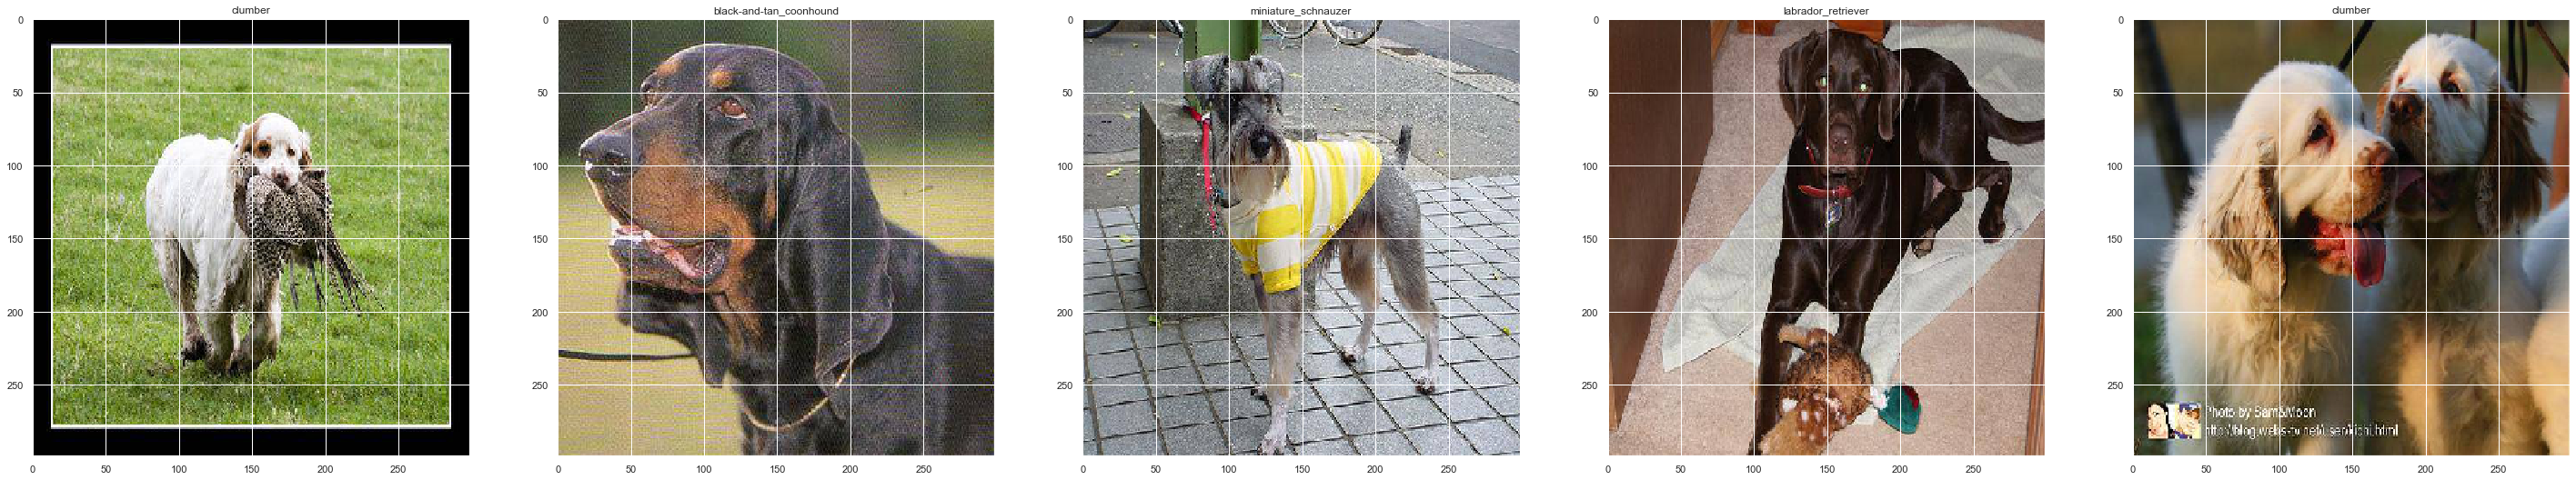

In [ ]:
path = "/Volumes/My Passport for Mac/data/dog-breeds/test2"
fileCount = len(getImagesFilePathsFromFolder(path))
#print(getImagesFilePathsFromFolder(path))
fig, ax = plt.subplots(1,fileCount, figsize=(50,50))
img_Counter=0;

for img_path in getImagesFilePathsFromFolder(path):
    print(img_path)
    breed = predict(get_x_test(img_path, 299, 299), loaded_model)[0]
    print(breed)
    ax[img_Counter].set_title(breed)
    ax[img_Counter].imshow(load_img(img_path, target_size=(299, 299)))
    img_Counter = img_Counter + 1



## Analyze Test Performance

In [ ]:
pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 22.9 MB/s eta 0:00:00


In [ ]:
import model_evaluation_utils as meu

In [ ]:
meu.get_metrics(true_labels=test_labels,
                predicted_labels=predictions)

Accuracy: 0.8784
Precision: 0.8904
Recall: 0.8784
F1 Score: 0.8755


In [ ]:
meu.display_classification_report(true_labels=test_labels,
                                  predicted_labels=predictions,
                                  classes=list(labels_ohe_names.columns))

                                precision    recall  f1-score   support

                 affenpinscher       0.88      0.96      0.92        24
                  afghan_hound       0.97      1.00      0.99        35
           african_hunting_dog       1.00      0.96      0.98        26
                      airedale       0.84      1.00      0.91        32
american_staffordshire_terrier       1.00      0.59      0.74        22
                   appenzeller       0.68      0.83      0.75        23
            australian_terrier       0.85      0.90      0.88        31
                       basenji       1.00      0.85      0.92        33
                        basset       0.89      0.96      0.92        25
                        beagle       0.83      0.97      0.90        31
            bedlington_terrier       1.00      1.00      1.00        27
          bernese_mountain_dog       0.97      1.00      0.99        34
       black-and-tan_coonhound       0.87      0.87      0.87  

In [ ]:
pip install pandas==0.25.3

  Using cached pandas-0.25.3.tar.gz (12.6 MB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
meu.display_confusion_matrix(true_labels=test_labels,
                                    predicted_labels=predictions,
                                    classes=list(labels_ohe_names.columns))

TypeError: ignored

iiiiiicd  The model achievpvdvd bkj,es a test accuracy of approxima##cdly __86%__

## Visualize Model Performance
Visualize model performance with actual images, labels and prediction confidence

RuntimeError: ignored

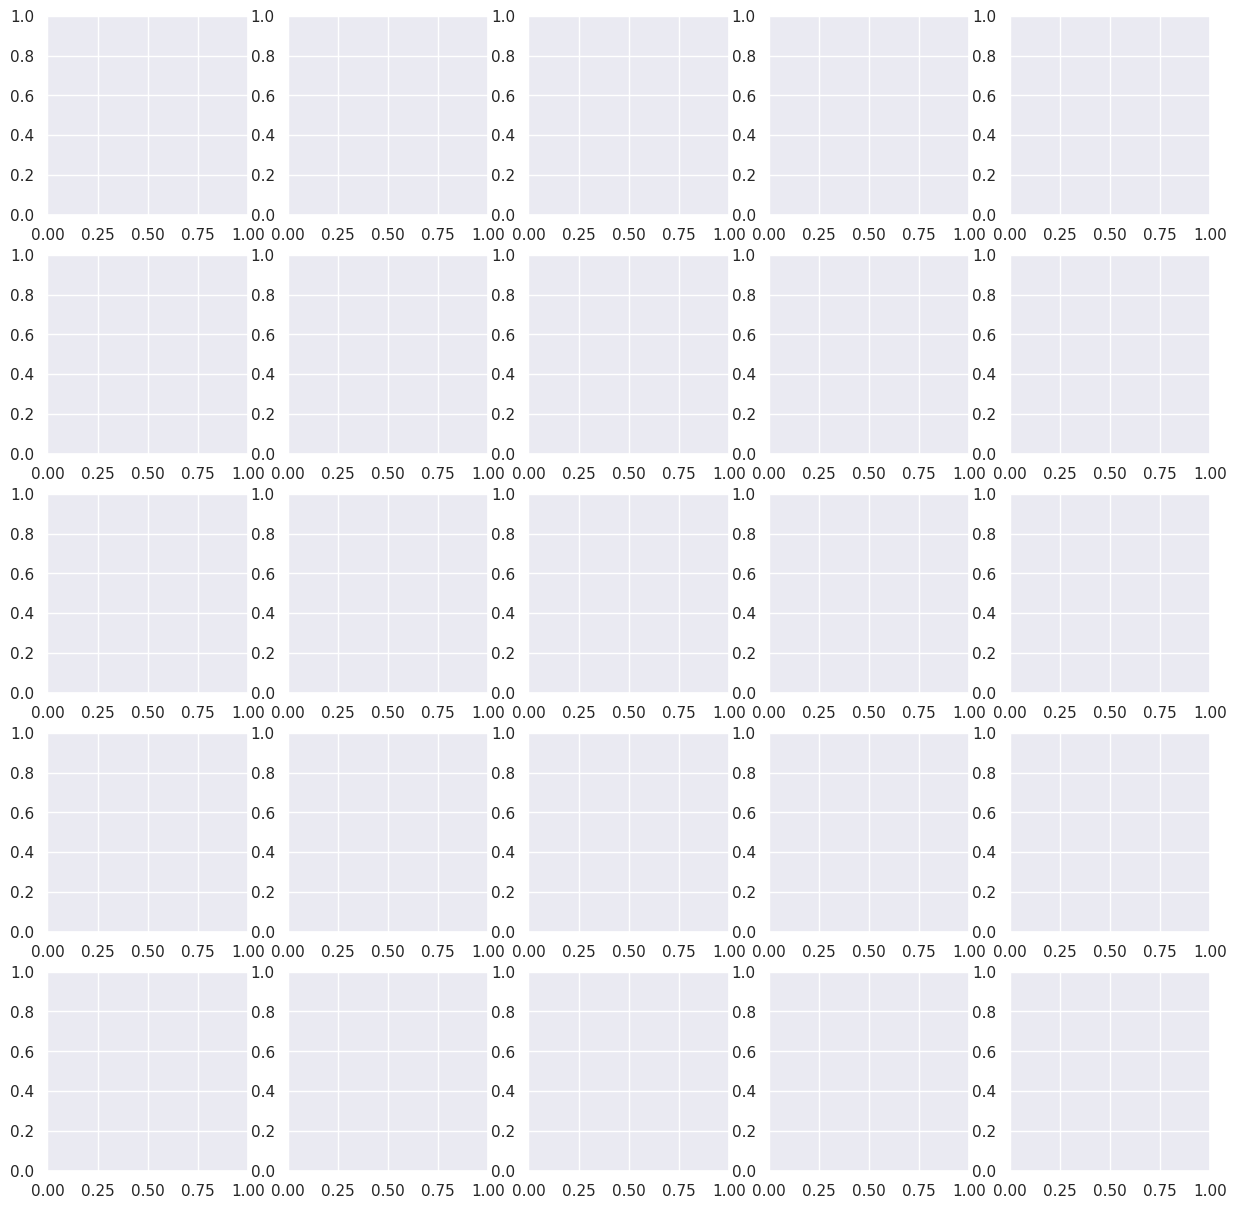

In [ ]:
grid_width = 5
grid_height = 5
f, ax = plt.subplots(grid_width, grid_height)
f.set_size_inches(15, 15)
batch_size = 25
dataset = x_test

label_dict = dict(enumerate(labels_ohe_names.columns.values))
model_input_shape = (1,)+model.get_input_shape_at(0)[1:]
random_batch_indx = np.random.permutation(np.arange(0,len(dataset)))[:batch_size]

img_idx = 0
for i in range(0, grid_width):
    for j in range(0, grid_height):
        actual_label = np.array(y_test)[random_batch_indx[img_idx]]
        prediction = model.predict(dataset[random_batch_indx[img_idx]].reshape(model_input_shape))[0]
        label_idx = np.argmax(prediction)
        predicted_label = label_dict.get(label_idx)
        conf = round(prediction[label_idx], 2)
        ax[i][j].axis('off')
        ax[i][j].set_title('Actual: '+actual_label+'\nPred: '+predicted_label + '\nConf: ' +str(conf))
        ax[i][j].imshow(dataset[random_batch_indx[img_idx]])
        img_idx += 1

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.5, hspace=0.55)